In [1]:
# Core imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set(style="whitegrid", context="notebook", font_scale=1.1)

In [2]:
file_id = "17fwaKfbgn5d4ZorILYGLDRrAvrF0jqqa"
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
names = pd.read_csv(download_url)
names.rename(columns={'num': "total_occurrences", 'sex': 'gender'}, inplace=True)
# Rename 'F' to 'Female' and 'M' to 'Male' for consistency
names["gender"] = names["gender"].replace({"F": "Female", "M": "Male"})
data = names.copy() # Will be used for anlysis later
data["decade"] = (data["year"] // 10) * 10
names.head()

,year,first_name,gender,total_occurrences
0,1920,Mary,Female,70982
1,1920,Dorothy,Female,36643
2,1920,Helen,Female,35097
3,1920,Margaret,Female,27994
4,1920,Ruth,Female,26101


In [3]:
names = names.sort_values(["year", "total_occurrences"], ascending=[True, False])
names["rank"] = names.groupby("year")["total_occurrences"].rank(method="first", ascending=False)

max_rank_per_year = names.groupby("year")["rank"].transform("max")
names["was_top10"] = names["rank"] <= 10
names["was_top20"] = names["rank"] <= 20
names["was_bottom10"] = names["rank"] >= (max_rank_per_year - 9)
names["was_bottom20"] = names["rank"] >= (max_rank_per_year - 19)
names["was_bottom50"] = names["rank"] >= (max_rank_per_year - 49)

# Rename 'F' to 'Female' and 'M' to 'Male' for consistency
names["gender"] = names["gender"].replace({"F": "Female", "M": "Male"})

male_df = names[names['gender'] == "Male"].copy()
female_df = names[names['gender'] == "Female"].copy()

# Ensure 'decade' column is created here for consistent availability
names["decade"] = (names["year"] // 10) * 10

In [4]:
# =========================================================
# Top 5 Initial Letter Trends by Decade (All Genders)
# Line Plot with decade-specific hover + lifetime legend
# =========================================================

import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, HTML

# ---------------------------------------------------------
# 1. Identify top 5 initials across all years (all genders)
# ---------------------------------------------------------

names = names.copy()

if "initial" not in names.columns:
    names["initial"] = names["first_name"].str[0]

top5_initials = (
    names.groupby("initial", as_index=False)["total_occurrences"]
    .sum()
    .sort_values("total_occurrences", ascending=False)
    .head(5)
)

top5_list = top5_initials["initial"].tolist()
top5_totals = dict(
    zip(top5_initials["initial"], top5_initials["total_occurrences"])
)

# Filter dataset to top initials only
df_top5 = names[names["initial"].isin(top5_list)].copy()
df_top5["decade"] = (df_top5["year"] // 10) * 10

# ---------------------------------------------------------
# 2. Build legend: top 3 names per initial (ALL years)
# ---------------------------------------------------------

legend_dict = {}
for initial in top5_list:
    sub = (
        df_top5[df_top5["initial"] == initial]
        .groupby("first_name", as_index=False)["total_occurrences"]
        .sum()
        .sort_values("total_occurrences", ascending=False)
        .head(3)
    )
    legend_dict[initial] = list(
        zip(sub["first_name"], sub["total_occurrences"])
    )

# ---------------------------------------------------------
# 3. Aggregate by decade and normalize to decade share
# ---------------------------------------------------------

decade_initial = (
    df_top5.groupby(["decade", "initial"], as_index=False)["total_occurrences"]
    .sum()
)

decade_totals = (
    decade_initial.groupby("decade")["total_occurrences"]
    .transform("sum")
)

decade_initial["share"] = (
    decade_initial["total_occurrences"] / decade_totals
)

# ---------------------------------------------------------
# 4. Pivot for line plot
# ---------------------------------------------------------

line_data = (
    decade_initial
    .pivot(index="initial", columns="decade", values="share")
    .fillna(0)
    .loc[top5_list]
)

# ---------------------------------------------------------
# 5. Prepare hover text (DECADE-SPECIFIC TOTALS)
# ---------------------------------------------------------

hover_text = {}

for initial in line_data.index:
    hover_text[initial] = []
    for decade in line_data.columns:
        occ = decade_initial.loc[
            (decade_initial["initial"] == initial) &
            (decade_initial["decade"] == decade),
            "total_occurrences"
        ].values[0]

        share = line_data.loc[initial, decade]

        hover_text[initial].append(
            f"Initial: {initial}<br>"
            f"Decade: {decade}<br>"
            f"Occurrences (this decade): {occ:,}<br>"
            f"Share of top initials: {share:.1%}"
        )

# ---------------------------------------------------------
# 6. Plotly line plot
# ---------------------------------------------------------

fig = go.Figure()

for initial in line_data.index:
    fig.add_trace(
        go.Scatter(
            x=line_data.columns.astype(str),
            y=line_data.loc[initial],
            mode="lines+markers",
            name=initial,
            text=hover_text[initial],
            hoverinfo="text",
            line=dict(width=3),
            marker=dict(size=8),
        )
    )

fig.update_layout(
    title="Top 5 Initial Letter Share by Decade (All Genders)",
    xaxis_title="Decade",
    yaxis_title="Share of Initial",
    yaxis=dict(
        tickformat=".0%",
        range=[0, line_data.values.max() * 1.1]
    ),
    autosize=False,
    width=900,
    height=400 + 30 * len(top5_list),
    margin=dict(l=80, r=80, t=60, b=100),
    legend=dict(
        title="Initial Letter",
        yanchor="top",
        y=0.99,
        x=1.02
    ),
)

fig.show()

# ---------------------------------------------------------
# 7. External legend (LIFETIME TOTALS + TOP NAMES)
# ---------------------------------------------------------

legend_html = (
    "<div style='font-size:14px; margin-top: 10px;'>"
    "<b>Most Common Names per Initial (All Years)</b>"
    "<ul style='margin:0; padding-left:1.2em;'>"
)

for initial in top5_list:
    names_list = legend_dict.get(initial, [])
    total_occ = top5_totals.get(initial, 0)
    names_str = ", ".join(
        [f"{n} ({occ:,})" for n, occ in names_list]
    )
    legend_html += (
        f"<li><b>{initial}</b> "
        f"(Total births: {total_occ:,}): "
        f"{names_str}</li>"
    )

legend_html += "</ul></div>"

display(HTML(legend_html))


In [5]:
# =========================================================
# Least Common Initial Letter Trends by Decade (All Genders)
# Line Plot with associated top names per initial (Plotly)
# =========================================================

import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, HTML

# ---------------------------------------------------------
# 1. Identify 5 least common initials across all years (all genders)
# ---------------------------------------------------------
bottom5_initials = (
    names.groupby("initial", as_index=False)["total_occurrences"]
    .sum()
    .sort_values("total_occurrences", ascending=True)
    .head(5)
)

bottom5_list = bottom5_initials["initial"].tolist()

# Filter dataset to bottom initials only
df_bottom5 = names[names["initial"].isin(bottom5_list)].copy()

# ---------------------------------------------------------
# 2. Build legend: top 3 names per initial (all years), with total occurrences
# ---------------------------------------------------------
legend_df = (
    df_bottom5.groupby(["initial", "first_name"], as_index=False)["total_occurrences"]
    .sum()
    .sort_values(["initial", "total_occurrences"], ascending=[True, False])
)

legend_dict = {}
for initial in bottom5_list:
    top_names = legend_df[legend_df["initial"] == initial].head(3)
    names_with_counts = [
        f"{row['first_name']} ({row['total_occurrences']:,})"
        for _, row in top_names.iterrows()
    ]
    legend_dict[initial] = names_with_counts

# ---------------------------------------------------------
# 3. Aggregate by decade and normalize to decade share
# ---------------------------------------------------------
decade_initial = (
    df_bottom5.groupby(["decade", "initial"], as_index=False)["total_occurrences"]
    .sum()
)

decade_totals = decade_initial.groupby("decade")["total_occurrences"].transform("sum")
decade_initial["share"] = decade_initial["total_occurrences"] / decade_totals

# ---------------------------------------------------------
# 4. Pivot for line plot
# ---------------------------------------------------------
line_data = (
    decade_initial
    .pivot(index="initial", columns="decade", values="share")
    .fillna(0)
    .loc[bottom5_list]  # ensure order matches bottom initials
)

# ---------------------------------------------------------
# 5. Prepare hover text with top names per initial and total occurrences
# ---------------------------------------------------------
# Get total occurrences per initial (all years)
initial_totals = (
    df_bottom5.groupby("initial")["total_occurrences"]
    .sum()
    .to_dict()
)

hover_text = {}
for initial in line_data.index:
    top_names = legend_dict.get(initial, [])
    name_str = ", ".join(top_names)
    total_occ = initial_totals.get(initial, 0)
    hover_text[initial] = []
    for decade in line_data.columns:
        share = line_data.loc[initial, decade]
        hover_text[initial].append(
            f"Initial: {initial}<br>Decade: {decade}<br>Share: {share:.3%}<br>Total occurrences: {total_occ:,}<br>Top names: {name_str}"
        )

# ---------------------------------------------------------
# 6. Plotly line plot (no annotation legend inside plot)
# ---------------------------------------------------------
fig = go.Figure()

for i, initial in enumerate(line_data.index):
    fig.add_trace(
        go.Scatter(
            x=line_data.columns.astype(str),
            y=line_data.loc[initial],
            mode="lines+markers",
            name=initial,
            text=hover_text[initial],
            hoverinfo="text",
            line=dict(width=3),
            marker=dict(size=8),
        )
    )

fig.update_layout(
    title="Least Common 5 Initial Letter Share by Decade (All Genders)",
    xaxis_title="Decade",
    yaxis_title="Share of Initial",
    yaxis=dict(tickformat=".2%", range=[0, line_data.values.max() * 1.1]),
    autosize=False,
    width=900,
    height=400 + 30 * len(bottom5_list),
    margin=dict(l=80, r=80, t=60, b=100),
    legend=dict(title="Initial Letter", yanchor="top", y=0.99, x=1.02),
)

fig.show()

# ---------------------------------------------------------
# 7. Display legend of most common names per initial outside the graph, with total occurrences
# ---------------------------------------------------------
legend_html = (
    "<div style='font-size:14px; margin-top: 10px;'>"
    "<b>Names per Initial (Least Common Initials)</b>"
    "<ul style='margin:0; padding-left:1.2em;'>"
)
for initial in bottom5_list:
    names_list = legend_dict.get(initial, [])
    total_occ = initial_totals.get(initial, 0)
    legend_html += f"<li><b>{initial}</b> (Total: {total_occ:,}): {', '.join(names_list)}</li>"
legend_html += "</ul></div>"

display(HTML(legend_html))

In [6]:
# =========================================================
# Top 5 Longest Name Trends by Decade (All Genders)
# Line Plot with corrected hover (Plotly)
# =========================================================

import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, HTML

# ---------------------------------------------------------
# 1. Identify top 5 longest names (tie-break by popularity)
# ---------------------------------------------------------
names["name_length"] = names["first_name"].str.len()

top5_longest = (
    names.groupby("first_name", as_index=False)
    .agg(
        name_length=("name_length", "max"),
        total_occurrences=("total_occurrences", "sum")
    )
    .sort_values(
        ["name_length", "total_occurrences"],
        ascending=[False, False]
    )
    .head(5)
)

top5_names = top5_longest["first_name"].tolist()

# Filter dataset
df_top5 = names[names["first_name"].isin(top5_names)].copy()
df_top5["decade"] = (df_top5["year"] // 10) * 10

# ---------------------------------------------------------
# 2. Build legend metadata (name length and lifetime totals)
# ---------------------------------------------------------
legend_dict = (
    top5_longest
    .set_index("first_name")[["name_length", "total_occurrences"]]
    .to_dict(orient="index")
)

# ---------------------------------------------------------
# 3. Aggregate by decade and normalize to decade share
# ---------------------------------------------------------
decade_name = (
    df_top5.groupby(["decade", "first_name"], as_index=False)["total_occurrences"]
    .sum()
)

decade_totals = decade_name.groupby("decade")["total_occurrences"].transform("sum")
decade_name["share"] = decade_name["total_occurrences"] / decade_totals

# ---------------------------------------------------------
# 4. Pivot for line plot
# ---------------------------------------------------------
line_data = (
    decade_name
    .pivot(index="first_name", columns="decade", values="share")
    .fillna(0)
    .loc[top5_names]
)

# ---------------------------------------------------------
# 4b. Pivot for decade-specific occurrences (NEW, SAFE)
# ---------------------------------------------------------
occ_data = (
    decade_name
    .pivot(index="first_name", columns="decade", values="total_occurrences")
    .fillna(0)
    .loc[top5_names]
)

# ---------------------------------------------------------
# 5. Corrected hover text (decade-consistent)
# ---------------------------------------------------------
hover_text = {}

for name in line_data.index:
    length = legend_dict[name]["name_length"]
    hover_text[name] = []

    for decade in line_data.columns:
        share = line_data.loc[name, decade]
        occ = int(occ_data.loc[name, decade])

        hover_text[name].append(
            f"Name: {name}"
            f"<br>Length: {length} characters"
            f"<br>Decade: {decade}"
            f"<br>Occurrences (this decade): {occ:,}"
            f"<br>Share: {share:.1%}"
        )

# ---------------------------------------------------------
# 6. Plotly line plot
# ---------------------------------------------------------
fig = go.Figure()

for name in line_data.index:
    fig.add_trace(
        go.Scatter(
            x=line_data.columns.astype(str),
            y=line_data.loc[name],
            mode="lines+markers",
            name=name,
            text=hover_text[name],
            hoverinfo="text",
            line=dict(width=3),
            marker=dict(size=8),
        )
    )

fig.update_layout(
    title="Top 5 Longest First Name Share by Decade (All Genders)",
    xaxis_title="Decade",
    yaxis_title="Share among Top 5 Longest Names",
    yaxis=dict(tickformat=".0%", range=[0, line_data.values.max() * 1.1]),
    autosize=False,
    width=900,
    height=400 + 30 * len(top5_names),
    margin=dict(l=80, r=80, t=60, b=100),
    legend=dict(title="First Name", yanchor="top", y=0.99, x=1.02),
)

fig.show()

# ---------------------------------------------------------
# 7. External legend (lifetime context only)
# ---------------------------------------------------------
legend_html = (
    "<div style='font-size:14px; margin-top: 10px;'>"
    "<b>Longest Names (Character Count & Total Occurrences — All Years)</b>"
    "<ul style='margin:0; padding-left:1.2em;'>"
)

for name in top5_names:
    length = legend_dict[name]["name_length"]
    total_occ = legend_dict[name]["total_occurrences"]
    legend_html += (
        f"<li><b>{name}</b>: {length} characters, {total_occ:,} total occurrences</li>"
    )

legend_html += "</ul></div>"

display(HTML(legend_html))


In [7]:
#How common are very long names in the population over time?
decade_totals = names.groupby("decade")["total_occurrences"].sum()

decade_name["global_share"] = (
    decade_name["total_occurrences"]
    / decade_name["decade"].map(decade_totals)
)
decade_name.head()

,decade,first_name,total_occurrences,share,global_share
0,1920,Elizabeth,139675,1.000000,0.011358
1,1930,Elizabeth,96478,1.000000,0.008801
2,1940,Elizabeth,116542,0.835355,0.006400
3,1940,Jacqueline,22970,0.164645,0.001261
4,1950,Christopher,73425,0.252818,0.002752


In [8]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px  # for colors

def plot_name_group(
    df,
    names=None,
    min_length=None,
    max_length=None,
    starts_with=None,
    ends_with=None,
    contains=None,
    title="Name Group Popularity"
):
    """
    df must contain:
      - year
      - first_name
      - gender
      - total_occurrences
    """

    # -------------------------------
    # 0. Base copy + name length/category
    # -------------------------------
    df = df.copy()
    df["name_length"] = df["first_name"].str.len()

    df["length_category"] = pd.cut(
        df["name_length"],
        bins=[0, 4, 7, 100],
        labels=["Short (≤4)", "Medium (5–7)", "Long (8+)"],
        right=True
    )

    # -------------------------------
    # 1. FILTERING (case-insensitive for letters)
    # -------------------------------
    group_df = df.copy()

    # exact list of names
    if names is not None:
        group_df = group_df[group_df["first_name"].isin(names)]

    # length filters
    if min_length is not None:
        group_df = group_df[group_df["name_length"] >= min_length]

    if max_length is not None:
        group_df = group_df[group_df["name_length"] <= max_length]

    # starts_with (case-insensitive)
    if starts_with is not None:
        s = starts_with.lower()
        group_df = group_df[group_df["first_name"].str.lower().str.startswith(s)]

    # ends_with (case-insensitive)
    if ends_with is not None:
        e = ends_with.lower()
        group_df = group_df[group_df["first_name"].str.lower().str.endswith(e)]

    # contains substring (case-insensitive)
    if contains is not None:
        c = contains.lower()
        group_df = group_df[group_df["first_name"].str.lower().str.contains(c)]

    if group_df.empty:
        print("No names match your filter. Try another letter or substring.")
        return

    # -------------------------------
    # 2. GLOBAL BIRTHS PER YEAR
    # -------------------------------
    total_births = (
        df.groupby("year")["total_occurrences"]
        .sum()
        .rename("total_births")
    )
    group_df = group_df.merge(total_births, on="year", how="left")

    group_df["global_share"] = (
        group_df["total_occurrences"] / group_df["total_births"]
    )

    # -------------------------------
    # 3. CATEGORY TOTALS PER YEAR (within filtered group)
    # -------------------------------
    category_totals = (
        group_df.groupby("year")["total_occurrences"]
        .sum()
        .rename("category_total")
    )
    group_df = group_df.merge(category_totals, on="year", how="left")

    group_df["share"] = (
        group_df["total_occurrences"] / group_df["category_total"]
    )

    # -------------------------------
    # 4. PERCENTAGES
    # -------------------------------
    group_df["share_percent"] = group_df["share"] * 100
    group_df["global_share_percent"] = group_df["global_share"] * 100

    # -------------------------------
    # 5. TOP 5 NAMES (by total occurrences in group)
    # -------------------------------
    top5 = (
        group_df.groupby("first_name")["total_occurrences"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .index
    )
    group_df = group_df[group_df["first_name"].isin(top5)]

    # -------------------------------
    # 6. PLOT with matching colors
    # -------------------------------
    fig = go.Figure()

    palette = px.colors.qualitative.Set2
    color_map = {name: palette[i % len(palette)] for i, name in enumerate(top5)}

    for name in top5:
        df_n = group_df[group_df["first_name"] == name].sort_values("year")

        # category share: solid line
        fig.add_trace(go.Scatter(
            x=df_n["year"],
            y=df_n["share_percent"],
            mode="lines",
            name=f"{name} (category share)",
            line=dict(width=3, color=color_map[name]),
        ))

        # global share: same color, dotted + star markers
        fig.add_trace(go.Scatter(
            x=df_n["year"],
            y=df_n["global_share_percent"],
            mode="lines+markers",
            name=f"{name} (global share)",
            line=dict(width=2, dash="dot", color=color_map[name]),
            marker=dict(symbol="star", size=8, color=color_map[name])
        ))

    fig.update_layout(
        title=title,
        xaxis_title="Year",
        yaxis_title="Share (%)",
        width=1100,
        height=600,
        legend=dict(
            x=1.02,
            y=1,
            xanchor="left",
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="black",
            borderwidth=1
        )
    )

    fig.show()


In [9]:
plot_name_group(data, contains="jph")


No names match your filter. Try another letter or substring.


In [10]:
plot_name_group(names, starts_with="Q")

No names match your filter. Try another letter or substring.


In [11]:
plot_name_group(data, min_length=9)


In [12]:
plot_name_group(data, starts_with="t")


In [13]:
!pip install -q jellyfish
!pip install -q rapidfuzz


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from rapidfuzz.distance import Levenshtein
import jellyfish
names_male = data[data["gender"] == "Male"].copy()
names_female = data[data["gender"] == "Female"].copy()
# Ensure 'soundex' column exists for both male and female DataFrames
names_male["soundex"] = names_male["first_name"].apply(jellyfish.soundex)
names_female["soundex"] = names_female["first_name"].apply(jellyfish.soundex)
names_male["name"] = names_male["first_name"] # ensure 'name' column exists as expected by the clustering logic
names_female["name"] = names_female["first_name"] # ensure 'name' column exists as expected by the clustering logic


# --- Cluster female names, replicating logic from previous cell for names_male ---
female_families = []
female_family_map = {}
current_female_family_id = 0

for _, g in names_female.groupby("soundex"):
    names_in_soundex_group = sorted(g["name"].unique())
    clusters = []

    for n in names_in_soundex_group:
        found_cluster = False
        for c_idx, c in enumerate(clusters):
            if any(
                Levenshtein.distance(n, x) <= 2
                and abs(len(n) - len(x)) <= 1          # length constraint
                and not (n.startswith(x) or x.startswith(n))  # prefix guard
                for x in c
            ):
                c.add(n)
                found_cluster = True
                break
        if not found_cluster:
            clusters.append({n})

    for c in clusters:
        if len(c) > 1:
            family_id = f"female_family_{current_female_family_id}"
            female_families.append(sorted(list(c)))
            for name_in_cluster in c:
                female_family_map[name_in_cluster] = family_id
            current_female_family_id += 1

names_female["name_family"] = names_female["name"].map(female_family_map)

# Similar logic for male names to create name_family, if not already done
male_families = []
male_family_map = {}
current_male_family_id = 0

for _, g in names_male.groupby("soundex"):
    names_in_soundex_group = sorted(g["name"].unique())
    clusters = []

    for n in names_in_soundex_group:
        found_cluster = False
        for c_idx, c in enumerate(clusters):
            if any(
                Levenshtein.distance(n, x) <= 2
                and abs(len(n) - len(x)) <= 1
                and not (n.startswith(x) or x.startswith(n))
                for x in c
            ):
                c.add(n)
                found_cluster = True
                break
        if not found_cluster:
            clusters.append({n})

    for c in clusters:
        if len(c) > 1:
            family_id = f"family_{current_male_family_id}"
            male_families.append(sorted(list(c)))
            for name_in_cluster in c:
                male_family_map[name_in_cluster] = family_id
            current_male_family_id += 1

names_male["name_family"] = names_male["name"].map(male_family_map)

# now that names_female has 'name_family' ---
male_family = (
    names_male[names_male["name_family"].notna()]
    .groupby("name_family")["first_name"]
    .unique()
    .reset_index()
    .sort_values("name_family")
)

female_family = (
    names_female[names_female["name_family"].notna()]
    .groupby("name_family")["first_name"]
    .unique()
    .reset_index()
    .sort_values("name_family")
)



print("Male Family Groups:")
display(male_family.head())
print("\nFemale Family Groups:")
display(female_family.head())

Male Family Groups:


,name_family,first_name
0,family_0,"[Adam, Aidan, Aiden, Ayden]"
1,family_1,"[Alan, Allen]"
2,family_10,"[Jason, Jaxon]"
3,family_11,"[Jayden, Jaden]"
4,family_12,"[John, Juan]"



Female Family Groups:


,name_family,first_name
0,female_family_0,"[Alice, Alicia]"
1,female_family_1,"[Alexandra, Alexandria]"
2,female_family_10,"[Christine, Christina]"
3,female_family_11,"[Carol, Carole, Carla]"
4,female_family_12,"[Carolyn, Caroline]"


In [15]:
import plotly.express as px

# 1. Aggregate total occurrences per male family
male_family_counts = (
    names_male[names_male["name_family"].notna()]
    .groupby("name_family")["total_occurrences"]
    .sum()
    .sort_values(ascending=False)
)
top_male_families = male_family_counts.head(5).index.tolist()

# 2. Prepare data for plotting
male_family_trends = (
    names_male[names_male["name_family"].isin(top_male_families)]
    .groupby(["decade", "name_family"])["total_occurrences"]
    .sum()
    .reset_index()
)

# 3. For legend, show example names from each family
male_family_to_names = (
    names_male[names_male["name_family"].isin(top_male_families)]
    .groupby("name_family")["first_name"]
    .unique()
    .apply(lambda names: ", ".join(sorted(names)[:3]) + ("..." if len(names) > 3 else ""))
    .to_dict()
)

male_family_trends["legend_label"] = male_family_trends["name_family"].map(
    lambda fam: f"{fam} ({male_family_to_names.get(fam, '')})"
)

# 4. Plot interactive line plot with legend outside
fig = px.line(
    male_family_trends,
    x="decade",
    y="total_occurrences",
    color="legend_label",
    markers=True,
    labels={"total_occurrences": "Total Occurrences", "decade": "Decade", "legend_label": "Name Family (examples)"},
    title="Popularity of Top 5 Male Name Families Over Decades"
)
fig.update_layout(
    legend=dict(
        title="Name Family (examples)",
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02,
        font=dict(size=12)
    ),
    margin=dict(r=200)
)
fig.show()

In [16]:
import plotly.express as px
import pandas as pd
from rapidfuzz.distance import Levenshtein
import jellyfish

# Reinitialize names_male and names_female from the original 'data' DataFrame
# and then process them to include the 'name_family' column,
# as the previous cell 'Qh1WFm5FYUJa' was not executed.
names_male = data[data["gender"] == "Male"].copy()
names_female = data[data["gender"] == "Female"].copy()

# Ensure 'soundex' column exists for both male and female DataFrames
names_male["soundex"] = names_male["first_name"].apply(jellyfish.soundex)
names_female["soundex"] = names_female["first_name"].apply(jellyfish.soundex)
names_male["name"] = names_male["first_name"] # ensure 'name' column exists
names_female["name"] = names_female["first_name"] # ensure 'name' column exists

# --- Cluster female names ---
female_families = []
female_family_map = {}
current_female_family_id = 0

for _, g in names_female.groupby("soundex"):
    names_in_soundex_group = sorted(g["name"].unique())
    clusters = []

    for n in names_in_soundex_group:
        found_cluster = False
        for c_idx, c in enumerate(clusters):
            if any(
                Levenshtein.distance(n, x) <= 2
                and abs(len(n) - len(x)) <= 1          # length constraint
                and not (n.startswith(x) or x.startswith(n))  # prefix guard
                for x in c
            ):
                c.add(n)
                found_cluster = True
                break
        if not found_cluster:
            clusters.append({n})

    for c in clusters:
        if len(c) > 1:
            family_id = f"female_family_{current_female_family_id}"
            female_families.append(sorted(list(c)))
            for name_in_cluster in c:
                female_family_map[name_in_cluster] = family_id
            current_female_family_id += 1

names_female["name_family"] = names_female["name"].map(female_family_map)

# --- Cluster male names ---
male_families = []
male_family_map = {}
current_male_family_id = 0

for _, g in names_male.groupby("soundex"):
    names_in_soundex_group = sorted(g["name"].unique())
    clusters = []

    for n in names_in_soundex_group:
        found_cluster = False
        for c_idx, c in enumerate(clusters):
            if any(
                Levenshtein.distance(n, x) <= 2
                and abs(len(n) - len(x)) <= 1
                and not (n.startswith(x) or x.startswith(n))
                for x in c
            ):
                c.add(n)
                found_cluster = True
                break
        if not found_cluster:
            clusters.append({n})

    for c in clusters:
        if len(c) > 1:
            family_id = f"family_{current_male_family_id}"
            male_families.append(sorted(list(c)))
            for name_in_cluster in c:
                male_family_map[name_in_cluster] = family_id
            current_male_family_id += 1

names_male["name_family"] = names_male["name"].map(male_family_map)


# 1. Aggregate total occurrences per female family
female_family_counts = (
    names_female[names_female["name_family"].notna()]
    .groupby("name_family")["total_occurrences"]
    .sum()
    .sort_values(ascending=False)
)
top_female_families = female_family_counts.head(5).index.tolist()

# 2. Prepare data for plotting
female_family_trends = (
    names_female[names_female["name_family"].isin(top_female_families)]
    .groupby(["decade", "name_family"])["total_occurrences"]
    .sum()
    .reset_index()
)

# 3. For legend, show example names from each family
female_family_to_names = (
    names_female[names_female["name_family"].isin(top_female_families)]
    .groupby("name_family")["first_name"]
    .unique()
    .apply(lambda names: ", ".join(sorted(names)[:3]) + ("..." if len(names) > 3 else ""))
    .to_dict()
)

female_family_trends["legend_label"] = female_family_trends["name_family"].map(
    lambda fam: f"{fam} ({female_family_to_names.get(fam, '')})"
)

# 4. Plot interactive line plot with legend outside
fig = px.line(
    female_family_trends,
    x="decade",
    y="total_occurrences",
    color="legend_label",
    markers=True,
    labels={"total_occurrences": "Total Occurrences", "decade": "Decade", "legend_label": "Name Family (examples)"},
    title="Popularity of Top 5 Female Name Families Over Decades"
)
fig.update_layout(
    legend=dict(
        title="Name Family (examples)",
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02,
        font=dict(size=12)
    ),
    margin=dict(r=200)
)
fig.show()

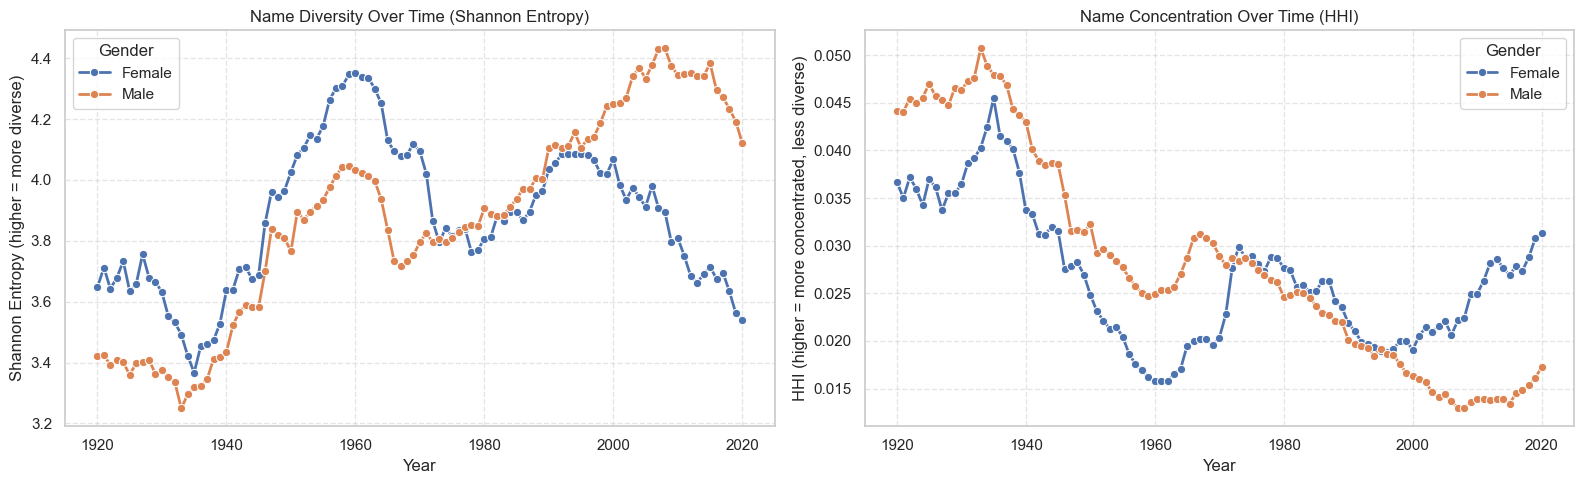

,year,gender,HHI,ShannonEntropy
0,1920,Female,0.036734,3.647633
1,1920,Male,0.044168,3.422228
2,1921,Female,0.035005,3.712286
3,1921,Male,0.044090,3.423705
4,1922,Female,0.037173,3.642878
5,1922,Male,0.045437,3.392943
6,1923,Female,0.035989,3.678149
7,1923,Male,0.044995,3.408734
8,1924,Female,0.034264,3.733253
9,1924,Male,0.045562,3.401027


In [17]:
# === Diversity indices: HHI & Shannon Entropy per year and sex ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: set a nice Seaborn theme
sns.set_theme(style="whitegrid")

# Function to compute HHI and Shannon Entropy
def diversity_metrics(df):
    """
    Compute HHI and Shannon entropy by year and gender, based on total_occurrences
    """
    # Group by year, gender, and first_name
    g = df.groupby(['year', 'gender', 'first_name'], as_index=False)['total_occurrences'].sum()

    # Total occurrences per year and gender
    g['total_year_gender'] = g.groupby(['year', 'gender'])['total_occurrences'].transform('sum')

    # Share of each name
    g['share'] = g['total_occurrences'] / g['total_year_gender']

    # HHI: sum of share^2
    hhi = g.groupby(['year', 'gender'])['share'].apply(lambda s: (s**2).sum()).rename('HHI')

    # Shannon entropy: -sum(p * ln p)
    entropy = g.groupby(['year', 'gender'])['share'].apply(lambda s: -(s * np.log(s + 1e-12)).sum()).rename('ShannonEntropy')

    # Combine results into one DataFrame
    out = pd.concat([hhi, entropy], axis=1).reset_index()

    # The 'gender' column already has 'Female' and 'Male' values, so no mapping needed.

    return out

# Compute diversity metrics
diversity = diversity_metrics(names)  # 'names' is your dataset

# === Plotting ===
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Shannon Entropy plot
sns.lineplot(data=diversity, x='year', y='ShannonEntropy', hue='gender', linewidth=2, marker="o", ax=ax[0])
ax[0].set_title("Name Diversity Over Time (Shannon Entropy)")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Shannon Entropy (higher = more diverse)")
ax[0].grid(True, linestyle='--', alpha=0.5)
ax[0].legend(title="Gender")

# HHI plot
sns.lineplot(data=diversity, x='year', y='HHI', hue='gender', linewidth=2, marker="o", ax=ax[1])
ax[1].set_title("Name Concentration Over Time (HHI)")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("HHI (higher = more concentrated, less diverse)")
ax[1].grid(True, linestyle='--', alpha=0.5)
ax[1].legend(title="Gender")

plt.tight_layout()
plt.show()

# Preview results
diversity.head(10)

In [18]:
# =========================================================
# Male vs Female Name Trends: Stability, Diversity, Trend Adoption
# =========================================================

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---------------------------------------------------------
# 0. Prepare data
# ---------------------------------------------------------
# Use 'data' DataFrame with columns: 'first_name', 'year', 'sex', 'total_occurrences', 'decade'

df_male = data[data["gender"] == "Male"].copy()
df_female = data[data["gender"] == "Female"].copy()

male_agg = df_male.groupby(["decade", "first_name"])["total_occurrences"].sum().reset_index()
female_agg = df_female.groupby(["decade", "first_name"])["total_occurrences"].sum().reset_index()

# ---------------------------------------------------------
# 1. Metric: Top 1 name share (stability)
# ---------------------------------------------------------
def top_share(df, top_n=1):
    shares = []
    for decade, g in df.groupby("decade"):
        total = g["total_occurrences"].sum()
        top_sum = g.nlargest(top_n, "total_occurrences")["total_occurrences"].sum()
        shares.append({"decade": decade, "top_share": top_sum / total})
    return pd.DataFrame(shares)

male_top1 = top_share(male_agg)
female_top1 = top_share(female_agg)

# ---------------------------------------------------------
# 2. Metric: Top 10 cumulative share (diversity)
# ---------------------------------------------------------
def top10_cumsum(df):
    result = []
    for decade, g in df.groupby("decade"):
        total = g["total_occurrences"].sum()
        top10 = g.nlargest(10, "total_occurrences")["total_occurrences"].sum()
        result.append({"decade": decade, "top10_share": top10 / total})
    return pd.DataFrame(result)

male_top10 = top10_cumsum(male_agg)
female_top10 = top10_cumsum(female_agg)

# ---------------------------------------------------------
# 3. Metric: New names per decade (trend adoption)
# ---------------------------------------------------------
def new_top_names(df, top_n=10):
    previous = set()
    changes = []
    for decade, g in df.groupby("decade"):
        top_names = set(g.nlargest(top_n, "total_occurrences")["first_name"])
        new_count = len(top_names - previous)
        changes.append({"decade": decade, "new_names": new_count})
        previous = top_names
    return pd.DataFrame(changes)

male_changes = new_top_names(male_agg)
female_changes = new_top_names(female_agg)

# ---------------------------------------------------------
# 4. Plot all metrics in subplots
# ---------------------------------------------------------
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=(
        "Top 1 Name Share (Stability)",
        "Top 10 Names Cumulative Share (Diversity)",
        "New Names in Top 10 per Decade (Trend Adoption)"
    )
)

# Different colors for each plot
# Top 1: blue (male), red (female)
# Top 10: purple (male), teal (female)
# New names: brown (male), pink (female)
colors = {
    "top1_male": "royalblue",
    "top1_female": "firebrick",
    "top10_male": "mediumpurple",
    "top10_female": "teal",
    "new_male": "saddlebrown",
    "new_female": "deeppink"
}

# Top 1 name share
fig.add_trace(go.Scatter(x=male_top1["decade"], y=male_top1["top_share"],
                         mode="lines+markers", name="Male (Top 1)", line=dict(color=colors["top1_male"])),
              row=1, col=1)
fig.add_trace(go.Scatter(x=female_top1["decade"], y=female_top1["top_share"],
                         mode="lines+markers", name="Female (Top 1)", line=dict(color=colors["top1_female"])),
              row=1, col=1)

# Top 10 cumulative share
fig.add_trace(go.Scatter(x=male_top10["decade"], y=male_top10["top10_share"],
                         mode="lines+markers", name="Male (Top 10)", line=dict(color=colors["top10_male"])),
              row=2, col=1)
fig.add_trace(go.Scatter(x=female_top10["decade"], y=female_top10["top10_share"],
                         mode="lines+markers", name="Female (Top 10)", line=dict(color=colors["top10_female"])),
              row=2, col=1)

# New names per decade
fig.add_trace(go.Scatter(x=male_changes["decade"], y=male_changes["new_names"],
                         mode="lines+markers", name="Male (New Names)", line=dict(color=colors["new_male"])),
              row=3, col=1)
fig.add_trace(go.Scatter(x=female_changes["decade"], y=female_changes["new_names"],
                         mode="lines+markers", name="Female (New Names)", line=dict(color=colors["new_female"])),
              row=3, col=1)

# Layout
fig.update_layout(
    height=900,
    width=900,
    title_text="Male vs Female Name Trends Over Time",
    legend=dict(y=0.5, traceorder="normal"),
    yaxis1=dict(tickformat=".0%", title="Top 1 Share"),
    yaxis2=dict(tickformat=".0%", title="Top 10 Share"),
    yaxis3=dict(title="New Names per Decade"),
    xaxis3=dict(title="Decade")
)

fig.show()

In [19]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# --- PREPARE DATA ---
df_m = data[data["gender"] == "Male"].copy() # Changed from "M" to "Male"
df_f = data[data["gender"] == "Female"].copy() # Changed from "F" to "Female"

def top1(df):
    rows = []
    for decade, g in df.groupby("decade"):
        top = g.nlargest(1, "total_occurrences").iloc[0]
        total = g["total_occurrences"].sum()
        rows.append({
            "decade": decade,
            "name": top["first_name"],
            "share": top["total_occurrences"] / total
        })
    return pd.DataFrame(rows)

male_top1 = top1(df_m)
female_top1 = top1(df_f)

# --- 1. SLOPEGRAPH OF TOP-1 NAMES ---
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    x=male_top1["decade"], y=male_top1["share"],
    mode="lines+markers+text",
    text=male_top1["name"],
    textposition="top center",
    name="Male",
    line=dict(color="blue")
))

fig1.add_trace(go.Scatter(
    x=female_top1["decade"], y=female_top1["share"],
    mode="lines+markers+text",
    text=female_top1["name"],
    textposition="bottom center",
    name="Female",
    line=dict(color="red")
))

fig1.update_layout(
    title="Slopegraph: Top-1 Name per Decade",
    yaxis=dict(tickformat=".0%"),
    width=700,
    height=400
)
fig1.show()

# --- 2. VOLATILITY INDEX ---
vol_df = pd.DataFrame({
    "gender": ["Male", "Female"],
    "volatility": [
        male_top1["share"].std(),
        female_top1["share"].std()
    ]
})

fig2 = px.bar(
    vol_df, x="gender", y="volatility",
    title="Volatility Index (Std Dev of Top-1 Share)",
    text="volatility"
)
fig2.update_layout(
    yaxis=dict(tickformat=".0%"),
    width=700,
    height=400
)
fig2.show()

# --- 3. NAME TURNOVER (NEW NAMES ENTERING TOP-10) ---
def turnover(df):
    prev = set()
    rows = []
    for decade, g in df.groupby("decade"):
        top10 = set(g.nlargest(10, "total_occurrences")["first_name"])
        new = top10 - prev
        rows.append({"decade": decade, "new_names": len(new)})
        prev = top10
    return pd.DataFrame(rows)

male_turn = turnover(df_m)
female_turn = turnover(df_f)

fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=male_turn["decade"], y=male_turn["new_names"],
    mode="lines+markers", name="Male", line=dict(color="purple")
))
fig3.add_trace(go.Scatter(
    x=female_turn["decade"], y=female_turn["new_names"],
    mode="lines+markers", name="Female", line=dict(color="orange")
))
fig3.update_layout(
    title="Name Turnover: New Names Entering Top-10 Each Decade",
    yaxis_title="New Names",
    width=700,
    height=400
)
fig3.show()

# --- 4. CONCENTRATION INDEX (HHI) ---
def hhi(df):
    rows = []
    for decade, g in df.groupby("decade"):
        total = g["total_occurrences"].sum()
        shares = (g["total_occurrences"] / total) ** 2
        rows.append({"decade": decade, "HHI": shares.sum()})
    return pd.DataFrame(rows)

male_hhi = hhi(df_m)
female_hhi = hhi(df_f)

# EXCLUDE 2020 (incomplete decade)
male_hhi = male_hhi[male_hhi["decade"] < 2020]
female_hhi = female_hhi[female_hhi["decade"] < 2020]

fig4 = go.Figure()
fig4.add_trace(go.Scatter(
    x=male_hhi["decade"], y=male_hhi["HHI"],
    mode="lines+markers", name="Male", line=dict(color="blue"),
    hovertemplate="Decade: %{x}<br>Male HHI: %{y:.4f}<extra></extra>"
))
fig4.add_trace(go.Scatter(
    x=female_hhi["decade"], y=female_hhi["HHI"],
    mode="lines+markers", name="Female", line=dict(color="red"),
    hovertemplate="Decade: %{x}<br>Female HHI: %{y:.4f}<extra></extra>"
))
fig4.update_layout(
    title="Concentration Index (HHI) by Decade: Measures Name Diversity (Excluding 2020)",
    yaxis_title="HHI (Higher Value = Less Diversity)",
    width=700,
    height=400
)
fig4.show()

In [20]:
# =========================================================
# Gender-Neutral Names: Male vs Female Share Over Time
# =========================================================

import pandas as pd
import numpy as np
import plotly.express as px

# ---------------------------------------------------------
# 0. Identify names appearing in BOTH sexes at least once
# ---------------------------------------------------------
names_by_sex = names.groupby(['first_name', 'gender'])['total_occurrences'].sum().reset_index()
both_sexes = names_by_sex['first_name'].value_counts()
unisex_names = both_sexes[both_sexes == 2].index.tolist()

# ---------------------------------------------------------
# 1. Overall balance: find names closest to 50/50
# ---------------------------------------------------------
overall = (
    names[names['first_name'].isin(unisex_names)]
    .groupby(['first_name', 'gender'])['total_occurrences'].sum()
    .reset_index()
    .pivot(index='first_name', columns='gender', values='total_occurrences')
    .fillna(0)
)

overall['male_share'] = overall['Male'] / (overall['Male'] + overall['Female'])
overall['female_share'] = overall['Female'] / (overall['Male'] + overall['Female'])

closest_names = (
    (overall['male_share'] - 0.5).abs()
    .sort_values()
    .head(10)
    .index
    .tolist()
)

# ---------------------------------------------------------
# 2. Compute yearly male and female shares for selected names
# ---------------------------------------------------------
yearly = (
    names[names['first_name'].isin(closest_names)]
    .groupby(['year', 'first_name', 'gender'])['total_occurrences']
    .sum()
    .reset_index()
    .pivot(index=['year', 'first_name'], columns='gender', values='total_occurrences')
    .fillna(0)
    .reset_index()
)

yearly['male_share'] = yearly['Male'] / (yearly['Male'] + yearly['Female'])
yearly['female_share'] = yearly['Female'] / (yearly['Male'] + yearly['Female'])

# ---------------------------------------------------------
# 3. Reshape to long format for Plotly
# ---------------------------------------------------------
yearly_long = yearly.melt(
    id_vars=['year', 'first_name'],
    value_vars=['male_share', 'female_share'],
    var_name='gender', # Keep 'gender' as the column name for the melt result
    value_name='share'
)

yearly_long['gender'] = yearly_long['gender'].map({
    'male_share': 'Male',
    'female_share': 'Female'
})

# ---------------------------------------------------------
# 4. Plotly line plot with faceting by name
# ---------------------------------------------------------
fig = px.line(
    yearly_long,
    x='year',
    y='share',
    color='gender',
    facet_col='first_name',
    facet_col_wrap=2, # Wrap facets into 2 columns for better layout
    markers=True,
    title='Gender-Neutral Names: Male vs Female Share by Year (Top 3 Closest to 50/50)',
    labels={'share': 'Gender Share (Proportion)', 'gender': 'Gender'},
    color_discrete_map={'Male': 'green', 'Female': 'purple'}
)

fig.add_hline(
    y=0.5,
    line_dash='dash',
    line_color='black',
    annotation_text='50/50 Balance',
    annotation_position='bottom right'
)

fig.update_layout(
    legend_title_text='Gender',
    height=600,
    width=900,
    yaxis_range=[0, 1] # Set y-axis to always go from 0 to 1
)
fig.update_yaxes(matches=None) # Allow independent y-axes for each facet
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # Clean up facet titles
fig.show()

# ---------------------------------------------------------
# 5. Display table of closest to 50/50 names
# ---------------------------------------------------------
display(overall.loc[closest_names][['male_share', 'female_share']].round(3))

gender,male_share,female_share
first_name,,
Jordan,0.801,0.199
Taylor,0.132,0.868
Terry,0.924,0.076


In [21]:
# ---------------------------------------------------------
# Prepare unique names by gender
# ---------------------------------------------------------
name_sex = (
    names.groupby(['first_name', 'gender'])['total_occurrences']
    .sum()
    .reset_index()
)

male_names = set(name_sex[name_sex['gender'] == 'Male']['first_name'])
female_names = set(name_sex[name_sex['gender'] == 'Female']['first_name'])

# ---------------------------------------------------------
# Find existing morphological pairs (strict)
# ---------------------------------------------------------
pairs = []

for f in female_names:
    for m in male_names:
        # female must strictly extend male (e.g. Paul -> Paula)
        if f.startswith(m) and len(f) > len(m):
            pairs.append((m, f))

pairs_df = pd.DataFrame(pairs, columns=['male_name', 'female_name'])

# ---------------------------------------------------------
# Attach usage counts
# ---------------------------------------------------------
usage = name_sex.pivot(index='first_name', columns='gender', values='total_occurrences').fillna(0)

pairs_df['male_usage'] = pairs_df['male_name'].map(usage['Male'])
pairs_df['female_usage'] = pairs_df['female_name'].map(usage['Female'])

# Keep meaningful pairs only
pairs_df = pairs_df[
    (pairs_df['male_usage'] > 0) &
    (pairs_df['female_usage'] > 0)
]

pairs_df.sort_values(['male_name', 'female_name']).head()


,male_name,female_name,male_usage,female_usage
12,Alex,Alexa,158677.0,33522.0
2,Alex,Alexandra,158677.0,167122.0
14,Alex,Alexandria,158677.0,5026.0
11,Alex,Alexis,158677.0,282149.0
1,Angel,Angela,157667.0,541553.0


In [22]:
import plotly.express as px

# Prepare data for plotting by melting male_usage and female_usage columns
df_melted = pairs_df.melt(
    id_vars=['male_name', 'female_name'],
    value_vars=['male_usage', 'female_usage'],
    var_name='gender',
    value_name='usage'
)

# Create combined label for x-axis
df_melted['pair'] = df_melted['male_name'] + ' / ' + df_melted['female_name']

# Map 'gender' values to cleaner labels
df_melted['gender'] = df_melted['gender'].map({
    'male_usage': 'Male',
    'female_usage': 'Female'
})

# Plot grouped bar chart
fig = px.bar(
    df_melted,
    x='pair',
    y='usage',
    color='gender',
    barmode='group',
    labels={'pair': 'Name Pair (Male / Female)', 'usage': 'Total Usage', 'gender': 'Gender'},
    title='Usage Comparison of Male and Female Name Pairs'
)

# Improve x-axis label appearance
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_tickfont=dict(size=10),
    width=900,
    height=500
)

fig.show()


In [23]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---------------------------------------------------------
# 1. Prepare unique names by sex
# ---------------------------------------------------------
name_sex = (
    names.groupby(['first_name', 'gender'])['total_occurrences']
    .sum()
    .reset_index()
)

male_names = set(name_sex[name_sex['gender'] == 'Male']['first_name'])
female_names = set(name_sex[name_sex['gender'] == 'Female']['first_name'])

# ---------------------------------------------------------
# 2. Find morphological pairs (relaxed rule)
# ---------------------------------------------------------
pairs = []
for f in female_names:
    for m in male_names:
        # female must strictly extend male (e.g. Paul -> Paula)
        # Relaxed rule: starts with first 3 letters and female name is longer
        if f.startswith(m[:3]) and len(f) > len(m):
            pairs.append((m, f))

pairs_df = pd.DataFrame(pairs, columns=['male_name', 'female_name'])

# ---------------------------------------------------------
# 3. Attach usage counts
# ---------------------------------------------------------
usage = name_sex.pivot(index='first_name', columns='gender', values='total_occurrences').fillna(0)

pairs_df['male_usage'] = pairs_df['male_name'].map(usage['Male'])
pairs_df['female_usage'] = pairs_df['female_name'].map(usage['Female'])

# Keep meaningful pairs only
pairs_df = pairs_df[
    (pairs_df['male_usage'] > 0) &
    (pairs_df['female_usage'] > 0)
]

# ---------------------------------------------------------
# 4. Choose top 10 pairs by total usage (sum of male+female usage)
# ---------------------------------------------------------
pairs_df['total_usage'] = pairs_df['male_usage'] + pairs_df['female_usage']
example_pairs = pairs_df.sort_values('total_usage', ascending=False).head(10)

# ---------------------------------------------------------
# 5. Extract all names involved in pairs
# ---------------------------------------------------------
pair_names = pd.unique(example_pairs[['male_name', 'female_name']].values.ravel())

# ---------------------------------------------------------
# 6. Prepare decade usage
# ---------------------------------------------------------
# Ensure 'data' DataFrame has 'decade' column before proceeding
data = data.copy() # Make a copy to avoid SettingWithCopyWarning
if 'decade' not in data.columns:
    data['decade'] = (data['year'] // 10) * 10

df_pairs = data[data['first_name'].isin(pair_names)]

decade_usage = (
    df_pairs
    .groupby(['decade', 'first_name', 'gender'], as_index=False)
    ['total_occurrences']
    .sum()
)

# ---------------------------------------------------------
# 7. Plot using Plotly
# ---------------------------------------------------------

# Create subplots for each name pair
num_rows = 2
num_cols = 5
fig = make_subplots(
    rows=num_rows,
    cols=num_cols,
    subplot_titles=[f"{row['male_name']} vs {row['female_name']}" for _, row in example_pairs.iterrows()],
    vertical_spacing=0.15,
    horizontal_spacing=0.08
)

colors = {'Male': 'purple', 'Female': 'orange'} # Define consistent colors

for i, (_, row) in enumerate(example_pairs.iterrows()):
    male = row['male_name']
    female = row['female_name']

    m_data = decade_usage[(decade_usage['first_name'] == male) & (decade_usage['gender'] == 'Male')]
    f_data = decade_usage[(decade_usage['first_name'] == female) & (decade_usage['gender'] == 'Female')]

    current_row = (i // num_cols) + 1
    current_col = (i % num_cols) + 1

    # Add trace for male name
    fig.add_trace(
        go.Scatter(
            x=m_data['decade'],
            y=m_data['total_occurrences'],
            mode='lines+markers',
            name="Male" if i == 0 else None, # Set name to "Male" only for the first male trace
            marker=dict(symbol='circle', size=8),
            line=dict(color=colors['Male'], width=3),
            hovertemplate=f"<b>Name: {male}</b><br>Decade: %{{x}}<br>Occurrences: %{{y:,}}<extra></extra>",
            showlegend=True if i == 0 else False # Show legend only for the first male trace
        ),
        row=current_row, col=current_col
    )

    # Add trace for female name
    fig.add_trace(
        go.Scatter(
            x=f_data['decade'],
            y=f_data['total_occurrences'],
            mode='lines+markers',
            name="Female" if i == 0 else None, # Set name to "Female" only for the first female trace
            marker=dict(symbol='square', size=8),
            line=dict(color=colors['Female'], dash='dash', width=3),
            hovertemplate=f"<b>Name: {female}</b><br>Decade: %{{x}}<br>Occurrences: %{{y:,}}<extra></extra>",
            showlegend=True if i == 0 else False # Show legend only for the first female trace
        ),
        row=current_row, col=current_col
    )

# Update layout for the entire figure
fig.update_layout(
    title_text="Usage Trends of Top 10 Male/Female Name Pairs Over Decades",
    height=700, # Increased height
    width=1400, # Increased width
    showlegend=True,
    legend=dict(
        title="Gender", # Changed legend title
        orientation="h",
        yanchor="bottom",
        y=-0.2, # Position legend further below the plots
        xanchor="center",
        x=0.5
    )
)

# Update y-axis and x-axis labels for all subplots
for i in range(len(example_pairs)):
    current_row = (i // num_cols) + 1
    current_col = (i % num_cols) + 1
    fig.update_yaxes(title_text="Occurrences", row=current_row, col=current_col)
    # Add x-axis title only for the plots in the bottom row
    if current_row == num_rows:
        fig.update_xaxes(title_text="Decade", row=current_row, col=current_col)
    else:
        fig.update_xaxes(row=current_row, col=current_col)

fig.show()

Top 10 Longevity — Male
    first_name  active_years  peak_occ  peak_year  half_life_years
140     Joseph           101     32730       1956             53.0
117      James           101     94764       1947             25.0
135       John           101     88319       1947             25.0
235    William           101     66992       1947             25.0
41     Charles           101     40774       1947             24.0
220     Thomas           101     48648       1952             19.0
63       David           101     86323       1955             18.0
196     Robert            99     91647       1947             25.0
13     Anthony            86     25080       1990             23.0
171    Michael            85     92718       1957             37.0

Top 10 Longevity — Female
    first_name  active_years  peak_occ  peak_year  half_life_years
97   Elizabeth           101     20749       1990             20.0
213       Mary            84     73985       1921             44.0
237   Patri

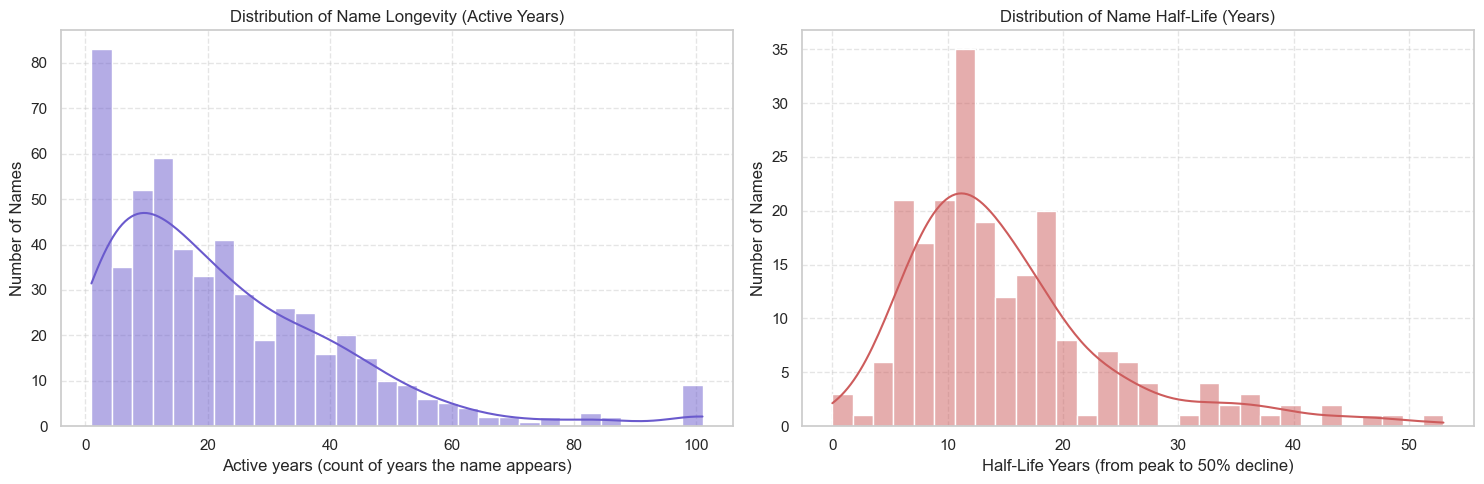

In [24]:
# === Longevity & Half-life ===
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: set a nice Seaborn theme
sns.set_theme(style="whitegrid")

def longevity_half_life(df):
    """
    Compute active years, peak occurrences/year, and half-life for names.
    Half-life is the years from peak to the first year with <= 50% of peak occurrences.
    """
    # active years
    active = df.groupby('first_name')['year'].nunique().rename('active_years')
    # peak occurrences & year
    peak_occ = df.groupby('first_name')['total_occurrences'].max().rename('peak_occ')
    peak_year = (
        df.loc[df.groupby('first_name')['total_occurrences'].idxmax(), ['first_name', 'year']]
        .set_index('first_name')['year'].rename('peak_year')
    )

    # half-life: years from peak to first year with <= 50% of peak occurrences
    def half_life_for_name(name_df):
        name_df = name_df.sort_values('year')
        peak = name_df['total_occurrences'].max()
        p_year = name_df.loc[name_df['total_occurrences'].idxmax(), 'year']
        after_peak = name_df[name_df['year'] >= p_year]
        hit = after_peak[after_peak['total_occurrences'] <= 0.5 * peak]
        if hit.empty:
            return np.nan
        return hit['year'].iloc[0] - p_year

    # Pass include_groups=False to avoid DeprecationWarning in future pandas versions
    hl = df.groupby('first_name').apply(half_life_for_name, include_groups=False).rename('half_life_years')

    out = pd.concat([active, peak_occ, peak_year, hl], axis=1).reset_index()
    return out

# Compute longevity metrics for male and female names
longevity_male = longevity_half_life(male_df).sort_values(['active_years', 'half_life_years'], ascending=[False, False]).head(10)
longevity_female = longevity_half_life(female_df).sort_values(['active_years', 'half_life_years'], ascending=[False, False]).head(10)

print("Top 10 Longevity — Male")
print(longevity_male)
print("\nTop 10 Longevity — Female")
print(longevity_female)

# Distribution of active years and half-life (all names)
all_longevity = longevity_half_life(names)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot distribution of active years
sns.histplot(all_longevity['active_years'], bins=30, color='slateblue', kde=True, ax=axes[0])
axes[0].set_title("Distribution of Name Longevity (Active Years)")
axes[0].set_xlabel("Active years (count of years the name appears)")
axes[0].set_ylabel("Number of Names")
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot distribution of half-life years (excluding NaN values)
sns.histplot(all_longevity['half_life_years'].dropna(), bins=30, color='indianred', kde=True, ax=axes[1])
axes[1].set_title("Distribution of Name Half-Life (Years)")
axes[1].set_xlabel("Half-Life Years (from peak to 50% decline)")
axes[1].set_ylabel("Number of Names")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

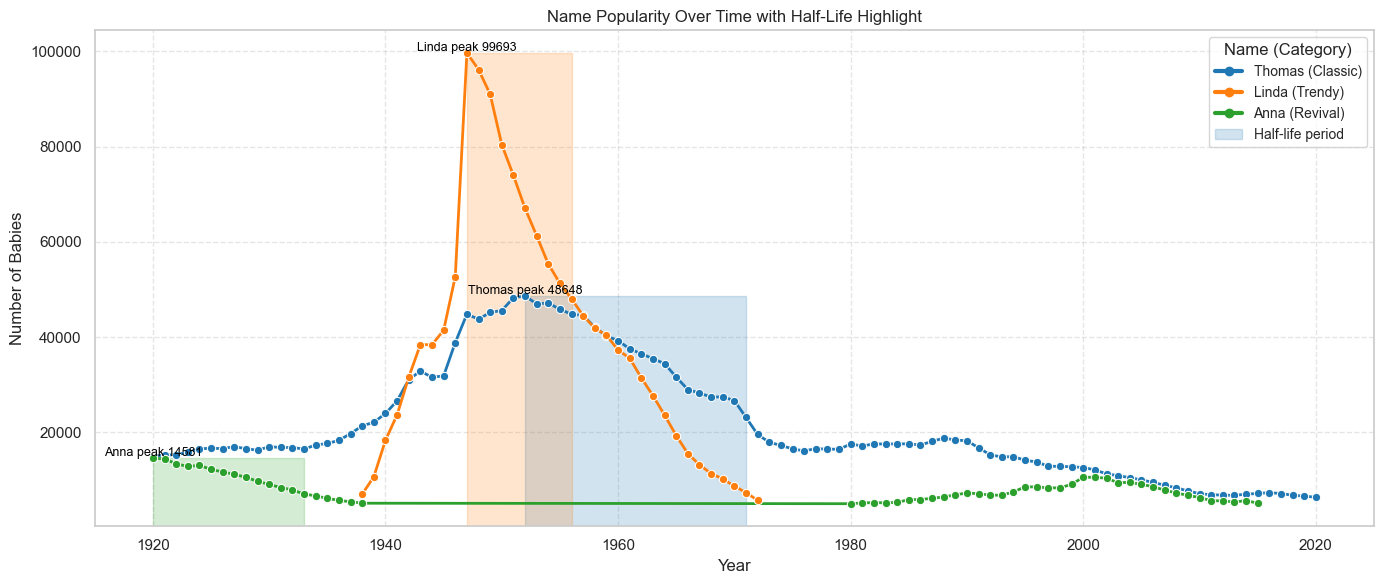

In [25]:
# === Name Lifecycle with Half-Life Highlight ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

sns.set_theme(style="whitegrid")

# --- Function to compute longevity and half-life ---
def longevity_half_life(df):
    active = df.groupby('first_name')['year'].nunique().rename('active_years')
    peak_occ = df.groupby('first_name')['total_occurrences'].max().rename('peak_occ')
    peak_year = df.loc[df.groupby('first_name')['total_occurrences'].idxmax(), ['first_name', 'year']]
    peak_year = peak_year.set_index('first_name')['year'].rename('peak_year')

    def half_life_for_name(name_df):
        name_df = name_df.sort_values('year')
        peak = name_df['total_occurrences'].max()
        p_year = name_df.loc[name_df['total_occurrences'].idxmax(), 'year']
        after_peak = name_df[name_df['year'] >= p_year]
        hit = after_peak[after_peak['total_occurrences'] <= 0.5 * peak]
        if hit.empty:
            return np.nan
        return hit['year'].iloc[0] - p_year

     # ✅ COLAB + FUTURE-PROOF FIX
    hl = (
        df.groupby('first_name', group_keys=False)
          .apply(half_life_for_name, include_groups=False)
          .rename('half_life_years')
    )

    return pd.concat([active, peak_occ, peak_year, hl], axis=1).reset_index()

all_longevity = longevity_half_life(names)

# --- Compute metrics ---
all_longevity = longevity_half_life(names)

# --- Select example names ---
classic_name = all_longevity.sort_values('active_years', ascending=False).iloc[0]['first_name']
trendy_name = all_longevity.sort_values(['peak_occ', 'active_years'], ascending=[False, True]).iloc[0]['first_name']

# Revival: gap > 10 years
revival_candidates = []
for name, group_ in names.groupby('first_name'):
    years = group_['year'].sort_values()
    if len(years) > 1 and years.diff().max() > 10:
        revival_candidates.append(name)
revival_name = revival_candidates[0] if revival_candidates else classic_name

selected_names = [classic_name, trendy_name, revival_name]
plot_data = names[names['first_name'].isin(selected_names)].copy()
plot_data['Category'] = plot_data['first_name'].map({
    classic_name: "Classic",
    trendy_name: "Trendy",
    revival_name: "Revival"
})

palette = {"Classic": "#1f77b4", "Trendy": "#ff7f0e", "Revival": "#2ca02c"}

# --- Plot ---
plt.figure(figsize=(14,6))

sns.lineplot(data=plot_data, x='year', y='total_occurrences',
             hue='Category', linewidth=2, marker="o", palette=palette)

plt.title("Name Popularity Over Time with Half-Life Highlight")
plt.xlabel("Year")
plt.ylabel("Number of Babies")
plt.grid(True, linestyle='--', alpha=0.5)

# --- Annotate peaks and shade half-life ---
for name in selected_names:
    subset = plot_data[plot_data['first_name']==name]
    if subset.empty:
        continue
    peak_row = subset.loc[subset['total_occurrences'].idxmax()]
    peak_year = peak_row['year']
    peak_value = peak_row['total_occurrences']
    half_life_years = all_longevity.loc[all_longevity['first_name']==name, 'half_life_years'].values[0]

    # Annotate peak
    plt.text(peak_year, peak_value + 500, f"{name} peak {int(peak_value)}",
             horizontalalignment='center', fontsize=9, color='black')

    # Highlight half-life as shaded rectangle
    if not np.isnan(half_life_years):
        plt.gca().add_patch(Rectangle(
            (peak_year, 0),           # x,y of rectangle start
            half_life_years,           # width = half-life in years
            peak_value,                # height
            color=palette[subset['Category'].iloc[0]],
            alpha=0.2
        ))

# --- Custom legend ---
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=palette["Classic"], lw=3, marker='o', label=f"{classic_name} (Classic)"),
    Line2D([0], [0], color=palette["Trendy"], lw=3, marker='o', label=f"{trendy_name} (Trendy)"),
    Line2D([0], [0], color=palette["Revival"], lw=3, marker='o', label=f"{revival_name} (Revival)"),
    Rectangle((0,0),1,1, color=palette["Classic"], alpha=0.2, label="Half-life period")
]
plt.legend(handles=legend_elements, title="Name (Category)", fontsize=10, title_fontsize=12, loc='upper right', frameon=True)

plt.tight_layout()
plt.show()


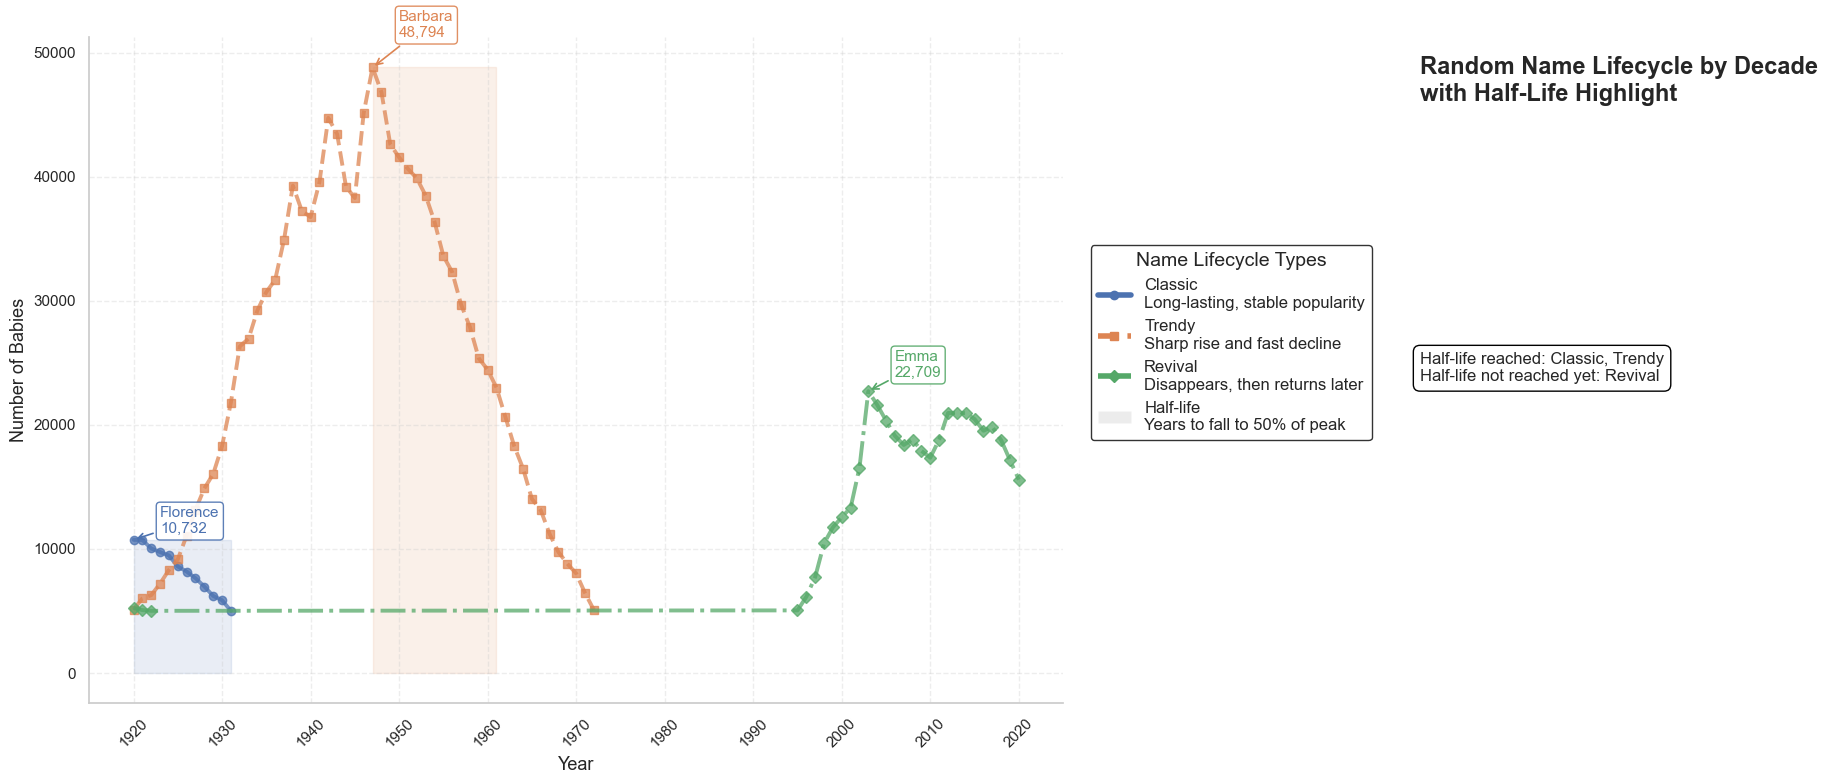

In [26]:
# === Random Name Lifecycle by Decade with Clear Legend & Half-Life Explanation ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D
import random

sns.set_theme(style="whitegrid")

# -------------------------------------------------
# 1. Longevity & half-life computation (COLAB SAFE)
# -------------------------------------------------
def longevity_half_life(df):
    active = df.groupby('first_name')['year'].nunique().rename('active_years')
    peak_occ = df.groupby('first_name')['total_occurrences'].max().rename('peak_occ')

    peak_year = (
        df.loc[df.groupby('first_name')['total_occurrences'].idxmax(),
               ['first_name', 'year']]
        .set_index('first_name')['year']
        .rename('peak_year')
    )

    def half_life_for_name(name_df):
        name_df = name_df.sort_values('year')
        peak = name_df['total_occurrences'].max()
        p_year = name_df.loc[name_df['total_occurrences'].idxmax(), 'year']
        after_peak = name_df[name_df['year'] >= p_year]
        hit = after_peak[after_peak['total_occurrences'] <= 0.5 * peak]
        return np.nan if hit.empty else hit['year'].iloc[0] - p_year

    # ✅ COLAB + FUTURE-PROOF FIX
    hl = (
        df.groupby('first_name', group_keys=False)
          .apply(half_life_for_name, include_groups=False)
          .rename('half_life_years')
    )

    return pd.concat([active, peak_occ, peak_year, hl], axis=1).reset_index()


all_longevity = longevity_half_life(names)

# -------------------------------------------------
# 2. Randomly select ONE name per category
# -------------------------------------------------
classic_candidates = all_longevity.sort_values(
    'active_years', ascending=False
)['first_name'].tolist()

trendy_candidates = all_longevity.sort_values(
    ['peak_occ', 'active_years'], ascending=[False, True]
)['first_name'].tolist()

revival_candidates = [
    name for name, g in names.groupby('first_name')
    if len(g['year']) > 1 and g['year'].sort_values().diff().max() > 10
]

classic_name = random.choice(classic_candidates)
trendy_name = random.choice(trendy_candidates)
revival_name = random.choice(revival_candidates) if revival_candidates else classic_name

selected_names = [classic_name, trendy_name, revival_name]

category_map = {
    classic_name: "Classic",
    trendy_name: "Trendy",
    revival_name: "Revival"
}

# -------------------------------------------------
# 3. Prepare plot data
# -------------------------------------------------
plot_data = names[names['first_name'].isin(selected_names)].copy()
plot_data['Category'] = plot_data['first_name'].map(category_map)

# -------------------------------------------------
# 4. Styling
# -------------------------------------------------
palette = {
    "Classic": "#4C72B0",
    "Trendy": "#DD8452",
    "Revival": "#55A868"
}
linestyles = {"Classic": "solid", "Trendy": "dashed", "Revival": "dashdot"}
markers = {"Classic": "o", "Trendy": "s", "Revival": "D"}

# -------------------------------------------------
# 5. Plot
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 8))

categories_with_half_life = []
categories_without_half_life = []

for name in selected_names:
    subset = plot_data[plot_data['first_name'] == name]
    cat = category_map[name]
    color = palette[cat]

    ax.plot(
        subset['year'], subset['total_occurrences'],
        color=color, linestyle=linestyles[cat], marker=markers[cat],
        linewidth=2.8, markersize=6, alpha=0.75
    )

    peak = subset.loc[subset['total_occurrences'].idxmax()]
    ax.annotate(
        f"{name}\n{peak['total_occurrences']:,}",
        xy=(peak['year'], peak['total_occurrences']),
        xytext=(peak['year'] + 3, peak['total_occurrences'] * 1.05),
        arrowprops=dict(arrowstyle="->", color=color, lw=1.2),
        fontsize=11, fontweight='normal', color=color,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec=color, alpha=0.9)
    )

    hl = all_longevity.loc[
        all_longevity['first_name'] == name, 'half_life_years'
    ].values[0]

    if not np.isnan(hl) and hl > 0:
        categories_with_half_life.append(cat)
        ax.add_patch(
            Rectangle(
                (peak['year'], 0),
                hl,
                peak['total_occurrences'],
                color=color,
                alpha=0.12,
                zorder=0
            )
        )
    else:
        categories_without_half_life.append(cat)

# -------------------------------------------------
# 6. Axes (decades only)
# -------------------------------------------------
years = plot_data['year']
decades = list(range((years.min() // 10) * 10,
                     (years.max() // 10 + 1) * 10, 10))
ax.set_xticks(decades)
ax.set_xticklabels(decades, rotation=45)

ax.set_xlabel("Year", fontsize=13)
ax.set_ylabel("Number of Babies", fontsize=13)
ax.grid(True, linestyle='--', alpha=0.35)

sns.despine(ax=ax)

# -------------------------------------------------
# 7. Legend
# -------------------------------------------------
legend_elements = [
    Line2D([0], [0], color=palette['Classic'], lw=4,
           linestyle=linestyles['Classic'], marker=markers['Classic'],
           label="Classic\nLong-lasting, stable popularity"),

    Line2D([0], [0], color=palette['Trendy'], lw=4,
           linestyle=linestyles['Trendy'], marker=markers['Trendy'],
           label="Trendy\nSharp rise and fast decline"),

    Line2D([0], [0], color=palette['Revival'], lw=4,
           linestyle=linestyles['Revival'], marker=markers['Revival'],
           label="Revival\nDisappears, then returns later"),
]

if categories_with_half_life:
    legend_elements.append(
        Patch(facecolor="gray", alpha=0.15,
              label="Half-life\nYears to fall to 50% of peak")
    )

ax.legend(
    handles=legend_elements,
    title="Name Lifecycle Types",
    title_fontsize=14,
    fontsize=12,
    loc="upper left",
    bbox_to_anchor=(1.02, 0.7),
    frameon=True,
    edgecolor="black"
)

# -------------------------------------------------
# 8. Explanation box
# -------------------------------------------------
explain_lines = []
if categories_with_half_life:
    explain_lines.append(
        f"Half-life reached: {', '.join(sorted(set(categories_with_half_life)))}"
    )
if categories_without_half_life:
    explain_lines.append(
        f"Half-life not reached yet: {', '.join(sorted(set(categories_without_half_life)))}"
    )

plt.gcf().text(
    1.02, 0.55,
    "\n".join(explain_lines),
    fontsize=12,
    ha="left",
    va="top",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.4")
)

# -------------------------------------------------
# 9. Title
# -------------------------------------------------
plt.gcf().text(
    1.02, 0.92,
    "Random Name Lifecycle by Decade\nwith Half-Life Highlight",
    fontsize=17, fontweight='bold', ha='left', va='top'
)

plt.tight_layout()
plt.show()


THe cell above generate a randome name to test the life span over decade